/tmp/ipykernel_594888/4093014877.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(item))


Model: ./model_save/CNN.pt
{'USD': 26021.993014292773, 'KRW-BTC': 0, 'v_USD': 26021.993014292773, 'v_KRW-BTC': 0.0002834979465327302, 'buy_count': 13, 'hold_count': 0, 'sell_count': 13}
Profit percentage: 0.4005498253573193
Cumulative return: 1.602459547384016
Volatility: 0.6845208855060616
Sharpe ratio: 2.3409943820769303


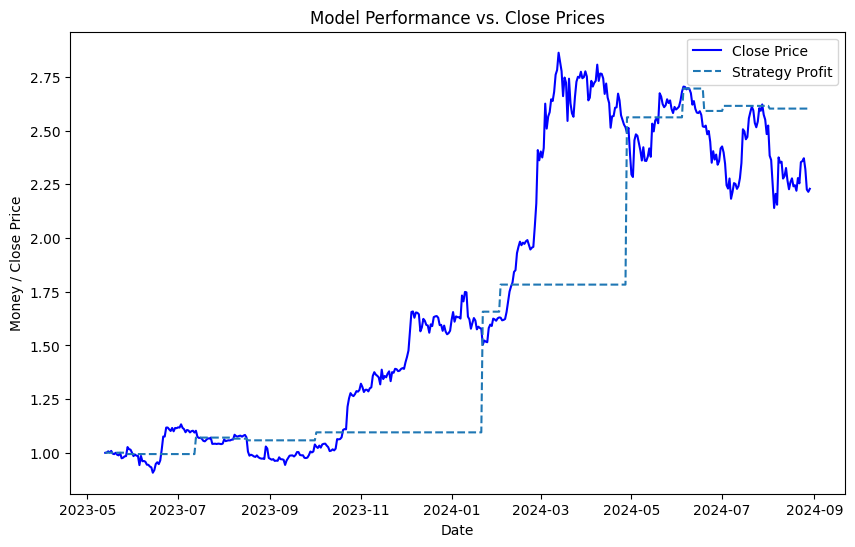

In [1]:
from architectures.cnn_ta import CNN
from architectures.vit import VisionTransformer

import torch
from torch import nn, Tensor, optim  # nn, Tensor, optim 관련 함수들 import
from torch.utils.data import DataLoader, TensorDataset, random_split  # 데이터셋 관련 함수들 import
import numpy as np  # 데이터 처리를 위한 numpy
import pandas as pd

from matplotlib import pyplot as plt  # 그래프 그리기 위한 matplotlib

model_path = './model_save/CNN.pt'

model = CNN()
etf_list = ['KRW-BTC']
THRESHOLD = '01'


class Wallet:
    def __init__(self, base_currency_name: str, stock_name: str, initial_money: float):
        self.base_currency_name: str = base_currency_name
        self.stock_name: str = stock_name
        self.initial_money: float = initial_money
        self.info: dict = {base_currency_name: initial_money, stock_name: 0, f"v_{base_currency_name}": initial_money, f"v_{stock_name}": 0,
                           "buy_count": 0, "hold_count": 0, "sell_count": 0}
        self.profit_percentage: float = 0
        #self.transactions: list = []

    def buy(self, stock_price: float, date: str):
        if self.info[self.base_currency_name] == 0:
            return
        self.info["buy_count"] += 1
        v_base = (self.info[self.base_currency_name] - 1)
        stock = v_base / stock_price
        # print(
        #     f"Bought {self.stock_name}: {round(stock, 2)} | USD: 0 | price: {round(stock_price, 2)} | date: {date}")
        self.info[self.stock_name] = stock
        self.info[f"v_{self.stock_name}"] = stock
        self.info[self.base_currency_name] = 0
        self.info[f"v_{self.base_currency_name}"] = v_base
        self.profit_percentage = v_base / self.initial_money - 1
    
    def hold(self, stock_price: float):
        self.info["hold_count"] += 1
        self.update_values(stock_price)
        return

    def sell(self, stock_price: float, date: str):
        if self.info[self.stock_name] == 0:
            return
        self.info["sell_count"] += 1
        base = self.info[self.stock_name] * stock_price - 1
        v_stock = base / stock_price
        # print(
        #     f"Sold   {self.stock_name}: 0 | USD: {round(base, 2)} | price: {round(stock_price, 2)} | date: {date}")
        self.info[self.base_currency_name] = base
        self.info[f"v_{self.base_currency_name}"] = base
        self.info[self.stock_name] = 0
        self.info[f"v_{self.stock_name}"] = v_stock
        self.profit_percentage = base / self.initial_money - 1

    def print_values(self):
        # if(self.profit_percentage > 0):
        print(self.info)
        print(f"Profit percentage: {self.profit_percentage/4}")
    
    def update_values(self, stock_price: float):
        if self.info[self.stock_name] > 0:
            self.info[f"v_{self.base_currency_name}"] = self.info[self.stock_name] * stock_price
        elif self.info[self.base_currency_name] > 0:
            self.info[f"v_{self.stock_name}"] = self.info[self.base_currency_name] / stock_price
        else:
            print("Error")
        self.profit_percentage = self.info[f"v_{self.base_currency_name}"] / \
            self.initial_money - 1
            
def load_dataset():
    x_test = []
    y_test = []
    for etf in etf_list:
        x_test.append(np.load(f"ETF/strategy/{THRESHOLD}/TestData/x_{etf}.npy"))
        y_test.append(np.load(f"ETF/strategy/{THRESHOLD}/TestData/y_{etf}.npy"))
    return x_test, y_test


def make_dataset(x_test, y_test):
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))


"""Loading the necessary stuff"""

listOfDates: list[np.ndarray] = []
listOfPrices: list[np.ndarray] = []
# keeps the prices for every stock one by one (listOfPrices[0] == prices for etf_list[0])

for etf in etf_list:
    listOfDates.append(
        np.load(f"ETF/strategy/{THRESHOLD}/Date/TestDate/{etf}.npy", allow_pickle=True))
    listOfPrices.append(
        np.load(f"ETF/strategy/{THRESHOLD}/Price/TestPrice/{etf}.npy", allow_pickle=True))


x_test, y_test = load_dataset()
datasets = make_dataset(x_test, y_test)


models = ['./model_save/CNN.pt']

profit_ranking = []

for item in models:
    model = CNN()
    model.load_state_dict(torch.load(item))
    model.eval()
    list_of_signals = []
    for dataset in datasets:
        predictions = model(dataset[0])
        predictions = torch.argmax(predictions, dim=1)
        list_of_signals.append(predictions)
    print('Model:', item)
    
    profits = []
    daily_moneys = []
    for signals, etf, price, dates in zip(list_of_signals, etf_list, listOfPrices, listOfDates):
        wallet = Wallet("USD", etf, 10000)
        daily_money = []
        for signal, price, date in zip(signals, price, dates):
            if signal == 0:
                wallet.buy(price, date)
            elif signal == 1:
                wallet.hold(price)
            elif signal == 2:
                wallet.sell(price, date)
            daily_money.append(wallet.info[f"v_{wallet.base_currency_name}"])
        wallet.print_values()
        # print("\n")
        profits.append(wallet.profit_percentage/4)
        daily_moneys.append(daily_money)
    
#calculate cumulatice return
    
daily_money = daily_moneys[0]
daily_money = [item/daily_money[0] for item in daily_money]

daily_return = [item/daily_money[i-1] for i, item in enumerate(daily_money)][1:]
cumulative_return = np.prod(daily_return) - 1
print(f"Cumulative return: {cumulative_return}")

vol = np.std(daily_return) * np.sqrt(len(daily_return)) 
print(f"Volatility: {vol}")

sharpe = cumulative_return / vol
print(f"Sharpe ratio: {sharpe}")



x = pd.date_range(start="2017-09-25", end="2024-08-29")
x = x[-len(daily_money):]
df = pd.read_csv('./utils/KRW-BTC.csv')
close_prices = df['Close'].iloc[-len(daily_money):]
close_prices = close_prices/close_prices.iloc[0]


# 그래프 제목 및 라벨 설정
plt.figure(figsize=(10, 6))
plt.title("Model Performance vs. Close Prices")
plt.xlabel("Date")
plt.ylabel("Money / Close Price")

# Close 가격 플롯
plt.plot(x, close_prices, label='Close Price', color='blue')
plt.plot(x, daily_money, label=f'Strategy Profit', linestyle='--')


# 범례 추가 및 그래프 출력
plt.legend()
plt.show() 

/tmp/ipykernel_594888/3612350312.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(item))


Model: ./model_save/ViT.pt
{'USD': 0, 'KRW-BTC': 0.00022064375545703256, 'v_USD': 18093.449878743042, 'v_KRW-BTC': 0.00022064375545703256, 'buy_count': 28, 'hold_count': 0, 'sell_count': 27}
Profit percentage: 0.20233624696857605
Cumulative return: 0.809344987874304
Volatility: 0.6957008198342471
Sharpe ratio: 1.1633520685905372


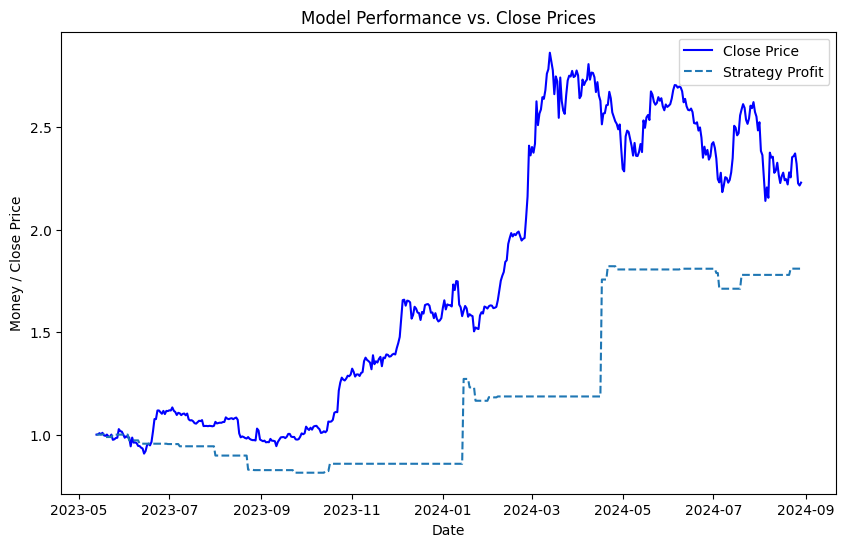

In [2]:
from architectures.cnn_ta import CNN
from architectures.vit import VisionTransformer

import torch
from torch import nn, Tensor, optim  # nn, Tensor, optim 관련 함수들 import
from torch.utils.data import DataLoader, TensorDataset, random_split  # 데이터셋 관련 함수들 import
import numpy as np  # 데이터 처리를 위한 numpy
import pandas as pd

from matplotlib import pyplot as plt  # 그래프 그리기 위한 matplotlib

model_path = './model_save/ViT.pt'

model = VisionTransformer()
etf_list = ['KRW-BTC']
THRESHOLD = '01'


class Wallet:
    def __init__(self, base_currency_name: str, stock_name: str, initial_money: float):
        self.base_currency_name: str = base_currency_name
        self.stock_name: str = stock_name
        self.initial_money: float = initial_money
        self.info: dict = {base_currency_name: initial_money, stock_name: 0, f"v_{base_currency_name}": initial_money, f"v_{stock_name}": 0,
                           "buy_count": 0, "hold_count": 0, "sell_count": 0}
        self.profit_percentage: float = 0
        #self.transactions: list = []

    def buy(self, stock_price: float, date: str):
        if self.info[self.base_currency_name] == 0:
            return
        self.info["buy_count"] += 1
        v_base = (self.info[self.base_currency_name] - 1)
        stock = v_base / stock_price
        # print(
        #     f"Bought {self.stock_name}: {round(stock, 2)} | USD: 0 | price: {round(stock_price, 2)} | date: {date}")
        self.info[self.stock_name] = stock
        self.info[f"v_{self.stock_name}"] = stock
        self.info[self.base_currency_name] = 0
        self.info[f"v_{self.base_currency_name}"] = v_base
        self.profit_percentage = v_base / self.initial_money - 1
    
    def hold(self, stock_price: float):
        self.info["hold_count"] += 1
        self.update_values(stock_price)
        return

    def sell(self, stock_price: float, date: str):
        if self.info[self.stock_name] == 0:
            return
        self.info["sell_count"] += 1
        base = self.info[self.stock_name] * stock_price - 1
        v_stock = base / stock_price
        # print(
        #     f"Sold   {self.stock_name}: 0 | USD: {round(base, 2)} | price: {round(stock_price, 2)} | date: {date}")
        self.info[self.base_currency_name] = base
        self.info[f"v_{self.base_currency_name}"] = base
        self.info[self.stock_name] = 0
        self.info[f"v_{self.stock_name}"] = v_stock
        self.profit_percentage = base / self.initial_money - 1

    def print_values(self):
        # if(self.profit_percentage > 0):
        print(self.info)
        print(f"Profit percentage: {self.profit_percentage/4}")
    
    def update_values(self, stock_price: float):
        if self.info[self.stock_name] > 0:
            self.info[f"v_{self.base_currency_name}"] = self.info[self.stock_name] * stock_price
        elif self.info[self.base_currency_name] > 0:
            self.info[f"v_{self.stock_name}"] = self.info[self.base_currency_name] / stock_price
        else:
            print("Error")
        self.profit_percentage = self.info[f"v_{self.base_currency_name}"] / \
            self.initial_money - 1
            
def load_dataset():
    x_test = []
    y_test = []
    for etf in etf_list:
        x_test.append(np.load(f"ETF/strategy/{THRESHOLD}/TestData/x_{etf}.npy"))
        y_test.append(np.load(f"ETF/strategy/{THRESHOLD}/TestData/y_{etf}.npy"))
    return x_test, y_test


def make_dataset(x_test, y_test):
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))


"""Loading the necessary stuff"""

listOfDates: list[np.ndarray] = []
listOfPrices: list[np.ndarray] = []
# keeps the prices for every stock one by one (listOfPrices[0] == prices for etf_list[0])

for etf in etf_list:
    listOfDates.append(
        np.load(f"ETF/strategy/{THRESHOLD}/Date/TestDate/{etf}.npy", allow_pickle=True))
    listOfPrices.append(
        np.load(f"ETF/strategy/{THRESHOLD}/Price/TestPrice/{etf}.npy", allow_pickle=True))


x_test, y_test = load_dataset()
datasets = make_dataset(x_test, y_test)


models = ['./model_save/ViT.pt']

profit_ranking = []

for item in models:
    model = VisionTransformer()
    model.load_state_dict(torch.load(item))
    model.eval()
    list_of_signals = []
    for dataset in datasets:
        predictions = model(dataset[0])
        predictions = torch.argmax(predictions, dim=1)
        list_of_signals.append(predictions)
    print('Model:', item)
    
    profits = []
    daily_moneys = []
    for signals, etf, price, dates in zip(list_of_signals, etf_list, listOfPrices, listOfDates):
        wallet = Wallet("USD", etf, 10000)
        daily_money = []
        for signal, price, date in zip(signals, price, dates):
            if signal == 0:
                wallet.buy(price, date)
            elif signal == 1:
                wallet.hold(price)
            elif signal == 2:
                wallet.sell(price, date)
            daily_money.append(wallet.info[f"v_{wallet.base_currency_name}"])
        wallet.print_values()
        # print("\n")
        profits.append(wallet.profit_percentage/4)
        daily_moneys.append(daily_money)
    
#calculate cumulatice return
    
daily_money = daily_moneys[0]
daily_money = [item/daily_money[0] for item in daily_money]

daily_return = [item/daily_money[i-1] for i, item in enumerate(daily_money)][1:]
cumulative_return = np.prod(daily_return) - 1
print(f"Cumulative return: {cumulative_return}")

vol = np.std(daily_return) * np.sqrt(len(daily_return)) 
print(f"Volatility: {vol}")

sharpe = cumulative_return / vol
print(f"Sharpe ratio: {sharpe}")



x = pd.date_range(start="2017-09-25", end="2024-08-29")
x = x[-len(daily_money):]
df = pd.read_csv('./utils/KRW-BTC.csv')
close_prices = df['Close'].iloc[-len(daily_money):]
close_prices = close_prices/close_prices.iloc[0]


# 그래프 제목 및 라벨 설정
plt.figure(figsize=(10, 6))
plt.title("Model Performance vs. Close Prices")
plt.xlabel("Date")
plt.ylabel("Money / Close Price")

# Close 가격 플롯
plt.plot(x, close_prices, label='Close Price', color='blue')
plt.plot(x, daily_money, label=f'Strategy Profit', linestyle='--')


# 범례 추가 및 그래프 출력
plt.legend()
plt.show() 